In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *
import gc

In [2]:
seed=1234
set_seed(seed, reproducible=True)
BATCH_SIZE = 32
epochs=5
n=5
beta=0
N_FOLDS=10
learning_rate=1e-5
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [3]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df['path'] = train_df['Id'].map(lambda x:str('../input/petfinder-pawpularity-score/train/'+x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [4]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [5]:
num_bins = int(np.floor(1+np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)

<AxesSubplot:>

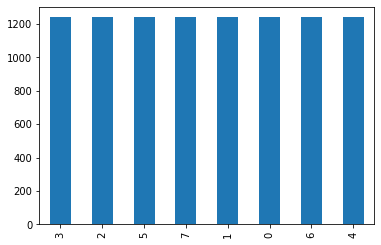

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [7]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [8]:
def get_data(fold):
    train_df_f = train_df.copy()
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    dls = ImageDataLoaders.from_df(train_df_f, 
                               valid_col='is_valid', 
                               seed=seed, 
                               fn_col='path',
                               label_col='norm_score',
                               y_block=RegressionBlock,
                               bs=BATCH_SIZE,
                               num_workers=8,
                               item_tfms=Resize(224),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))
    return dls


In [9]:
def get_learner(fold_num):
    data = get_data(fold_num)
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    return learn

In [10]:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str('../input/petfinder-pawpularity-score/test/'+x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [11]:
all_preds = []

for i in range(1, N_FOLDS+1):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=(i-1))
    learn.fit_one_cycle(epochs, learning_rate, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    dls = ImageDataLoaders.from_df(train_df, 
                               valid_pct=0.25, 
                               seed=seed,
                               fn_col='path', 
                               label_col='norm_score', 
                               y_block=RegressionBlock, 
                               bs=BATCH_SIZE,
                               num_workers=8,
                               item_tfms=Resize(224),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.tta(dl=test_dl, n=n, beta=beta)
    all_preds.append(preds)
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657841,0.650198,18.511196,07:06
1,0.646916,0.641386,17.410295,06:57
2,0.641230,0.639773,17.191681,06:58
3,0.637153,0.639360,17.124065,06:57
4,0.634405,0.639619,17.151358,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6501977443695068.
Better model found at epoch 1 with valid_loss value: 0.6413859724998474.
Better model found at epoch 2 with valid_loss value: 0.6397727131843567.
Better model found at epoch 3 with valid_loss value: 0.6393595337867737.


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656942,0.653622,19.057318,06:59
1,0.645469,0.645205,17.983870,06:57
2,0.640140,0.644352,17.851645,06:58
3,0.634143,0.644189,17.806343,06:58
4,0.634991,0.643857,17.785868,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6536222696304321.
Better model found at epoch 1 with valid_loss value: 0.6452047228813171.
Better model found at epoch 2 with valid_loss value: 0.644351601600647.
Better model found at epoch 3 with valid_loss value: 0.644189178943634.
Better model found at epoch 4 with valid_loss value: 0.6438568830490112.


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655387,0.652843,19.088633,06:57
1,0.644546,0.645280,18.080580,06:58
2,0.642271,0.642367,17.711666,06:57
3,0.639054,0.642053,17.657921,06:58
4,0.635210,0.641719,17.604294,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.652843177318573.
Better model found at epoch 1 with valid_loss value: 0.6452803015708923.
Better model found at epoch 2 with valid_loss value: 0.6423670649528503.
Better model found at epoch 3 with valid_loss value: 0.642053484916687.
Better model found at epoch 4 with valid_loss value: 0.6417186260223389.


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.659399,0.652518,19.016283,06:57
1,0.645578,0.644098,17.967138,06:56
2,0.639230,0.642704,17.787033,06:57
3,0.638488,0.640961,17.531019,06:57
4,0.634012,0.640923,17.532164,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6525180339813232.
Better model found at epoch 1 with valid_loss value: 0.6440979838371277.
Better model found at epoch 2 with valid_loss value: 0.6427043676376343.
Better model found at epoch 3 with valid_loss value: 0.640961229801178.
Better model found at epoch 4 with valid_loss value: 0.6409226059913635.


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656377,0.651414,18.848860,06:58
1,0.645787,0.641568,17.613171,06:57
2,0.642915,0.639538,17.325068,06:58
3,0.637247,0.639230,17.270706,06:58
4,0.636841,0.639027,17.255028,06:59


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6514140367507935.
Better model found at epoch 1 with valid_loss value: 0.6415676474571228.
Better model found at epoch 2 with valid_loss value: 0.639537513256073.
Better model found at epoch 3 with valid_loss value: 0.6392298340797424.
Better model found at epoch 4 with valid_loss value: 0.6390269994735718.


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657104,0.653014,18.854216,06:58
1,0.643018,0.646192,17.973011,06:57
2,0.640727,0.644452,17.777552,06:57
3,0.636313,0.644602,17.777233,06:57
4,0.636815,0.644761,17.788095,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6530135869979858.
Better model found at epoch 1 with valid_loss value: 0.6461917161941528.
Better model found at epoch 2 with valid_loss value: 0.6444517970085144.


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655925,0.647722,18.580610,06:57
1,0.646633,0.638943,17.410473,06:58
2,0.641099,0.636622,17.068159,06:58
3,0.636333,0.636197,16.996721,06:58
4,0.636370,0.636097,16.979494,06:59


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6477217674255371.
Better model found at epoch 1 with valid_loss value: 0.6389428377151489.
Better model found at epoch 2 with valid_loss value: 0.6366220712661743.
Better model found at epoch 3 with valid_loss value: 0.6361967921257019.
Better model found at epoch 4 with valid_loss value: 0.6360974311828613.


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657932,0.651774,18.807627,06:57
1,0.646807,0.643593,17.762106,06:57
2,0.639525,0.641204,17.496162,06:57
3,0.636098,0.641128,17.455067,06:59
4,0.636178,0.641288,17.476404,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6517743468284607.
Better model found at epoch 1 with valid_loss value: 0.6435927152633667.
Better model found at epoch 2 with valid_loss value: 0.6412040591239929.
Better model found at epoch 3 with valid_loss value: 0.6411276459693909.


In [12]:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
output_df = test_df[["Id"]].copy()
preds = np.mean(np.stack(all_preds), axis=0)
output_df["Pawpularity"] = preds*100
output_df.to_csv('submission.csv',index=False)